# Capstone project notebook

## Problem 4

## Predict Complaint Types
The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

## Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?
In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_ec7e1c7b8ff34439ae9b51c4905a817e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='7gf26IIZpQ7M8qG9Ftj39GvqCUZGoe9EiJJKQFDMy-1h',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ec7e1c7b8ff34439ae9b51c4905a817e.get_object(Bucket='edx1-donotdelete-pr-ffppmpbmudcobi',Key='nyc311.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_311 = pd.read_csv(body)
df_311.head()

,address_type,borough,city,closed_date,complaint_type,created_date,incident_address,incident_zip,latitude,location_type,longitude,resolution_description,status,street_name,unique_key
0,ADDRESS,BRONX,BRONX,2018-04-24T14:15:01.000,GENERAL,2017-12-12T10:05:40.000,383 EAST 162 STREET,10451.0,40.824952,RESIDENTIAL BUILDING,-73.913944,The Department of Housing Preservation and Dev...,Closed,EAST 162 STREET,37914383
1,ADDRESS,BRONX,BRONX,2018-04-24T14:15:02.000,GENERAL,2018-01-08T12:47:29.000,383 EAST 162 STREET,10451.0,40.824952,RESIDENTIAL BUILDING,-73.913944,The Department of Housing Preservation and Dev...,Closed,EAST 162 STREET,38152033
2,ADDRESS,QUEENS,Woodside,2018-04-24T21:29:42.000,PAINT/PLASTER,2018-01-08T22:33:51.000,60-10 47 AVENUE,11377.0,40.739912,RESIDENTIAL BUILDING,-73.904328,The Department of Housing Preservation and Dev...,Closed,47 AVENUE,38157143
3,ADDRESS,QUEENS,Astoria,2018-04-24T09:50:17.000,APPLIANCE,2018-01-12T17:09:03.000,34-15 31 STREET,11106.0,40.759282,RESIDENTIAL BUILDING,-73.927550,The Department of Housing Preservation and Dev...,Closed,31 STREET,38205215
4,ADDRESS,QUEENS,Astoria,2018-04-24T09:50:18.000,DOOR/WINDOW,2018-01-22T14:04:15.000,30-34 32 STREET,11102.0,40.765523,RESIDENTIAL BUILDING,-73.921410,The Department of Housing Preservation and Dev...,Closed,32 STREET,38275095


In [34]:
# Some imports
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from matplotlib.pylab import rcParams


### Read Bronx file

To prevent loading unnecesary data, we select the columns to load

In [3]:
body = client_ec7e1c7b8ff34439ae9b51c4905a817e.get_object(Bucket='edx1-donotdelete-pr-ffppmpbmudcobi',Key='bronxs.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
cols_to_read = [  'Address',
                  'BldgArea',
                  'BldgDepth',
                  'BuiltFAR',
                  'CommFAR',
                  'FacilFAR',
                  'Lot', 
                  'LotArea',
                  'LotDepth',
                  'NumBldgs',
                  'NumFloors',
                  'OfficeArea',
                  'ResArea',
                  'ResidFAR',
                  'RetailArea',
                  'YearBuilt',
                  'YearAlter1',
                  'ZipCode',
                  'YCoord',
                  'XCoord']
df_bronx_info = pd.read_csv(body, usecols=cols_to_read)

In [4]:
df_bronx_info.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### We create a subset pandas dataframe

With only the values to study, namely borough, address and location. After that we make and encoding setting BRONX as 1 and all others as 0


In [5]:
df_bronx_incidents = df_311[['complaint_type', 'incident_address', 'latitude', 'longitude', 'unique_key']].loc[df_311['borough'] == 'BRONX']
print('Number of Bronx incidents',df_bronx_incidents['unique_key'].count(),sep=' ')
df_bronx_incidents.head()

Number of Bronx incidents 1508988


,complaint_type,incident_address,latitude,longitude,unique_key
0,GENERAL,383 EAST 162 STREET,40.824952,-73.913944,37914383
1,GENERAL,383 EAST 162 STREET,40.824952,-73.913944,38152033
6,PAINT/PLASTER,2647 SEDGWICK AVENUE,40.869502,-73.904438,38278432
9,WATER LEAK,2647 SEDGWICK AVENUE,40.869502,-73.904438,38279902
10,WATER LEAK,2647 SEDGWICK AVENUE,40.869502,-73.904438,38281075


In [6]:
df_bronx_incidents['complaint_type'] = (df_bronx_incidents['complaint_type'] == 'HEAT/HOT WATER').astype(int)

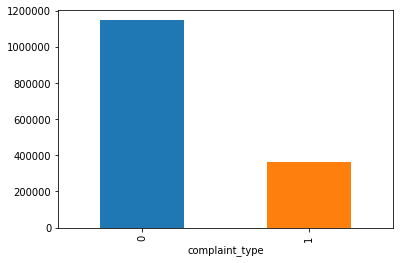

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
df_bronx_incidents.groupby('complaint_type').agg('complaint_type').count().plot.bar()

### We need to join incidents with building information

A left inner join is what we need

In [8]:
df_bronx = pd.merge(df_bronx_incidents, df_bronx_info, how='left', left_on=['incident_address'], right_on=['Address'])

In [9]:
print('Number of Bronx incidents and building information',df_bronx['unique_key'].count(),sep=' ')

Number of Bronx incidents and building information 1510149


### There are incident streets not available in the pluto file, so we just drop them

This is a problem with cardinality.

In [10]:
df_bronx.dropna(inplace=True)

### Let's get rid of the addresses

Let's see how many null values we have in the dataframe, and then eliminate them. Also we can select Lot as the index

In [11]:
df_bronx.drop(['Address', 'incident_address', 'unique_key'], axis=1, inplace=True)

### Eliminate duplicates

There are a lot of duplicates. We are cleaning them and it results in *_1,211,609_* rows

In [12]:
df_bronx.drop_duplicates(inplace=True)

### Let's define dependant and independant variables

In [13]:
y = np.asarray(df_bronx['complaint_type'])
predictors = df_bronx.columns.difference(['complaint_type'])

In [14]:
X = df_bronx[predictors]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
X.head(2)

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,...,ResArea,ResidFAR,RetailArea,XCoord,YCoord,YearAlter1,YearBuilt,ZipCode,latitude,longitude
2,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
10,54500.0,81.0,4.04,0.0,4.8,21.0,13500.0,90.00,1.0,5.0,...,50350.0,3.44,4150.0,1010610.0,235664.0,2011.0,1926.0,10455.0,40.813584,-73.905006


In [16]:
def xgb_model(train_data, train_label, test_data, test_label):
    clf = xgb.XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.05,
                           n_estimators=1000,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
    clf.fit(train_data, train_label, eval_metric='auc', verbose=True, eval_set=[(test_data, test_label)], early_stopping_rounds=100)
    y_pre = clf.predict(test_data)
    y_pro = clf.predict_proba(test_data)[:, 1]
    return clf 

In [17]:
model = xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-auc:0.512806
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.506687
[2]	validation_0-auc:0.509182
[3]	validation_0-auc:0.506149
[4]	validation_0-auc:0.505224
[5]	validation_0-auc:0.503046
[6]	validation_0-auc:0.502773
[7]	validation_0-auc:0.501305
[8]	validation_0-auc:0.499244
[9]	validation_0-auc:0.498232
[10]	validation_0-auc:0.497715
[11]	validation_0-auc:0.494176
[12]	validation_0-auc:0.492581
[13]	validation_0-auc:0.491001
[14]	validation_0-auc:0.490338
[15]	validation_0-auc:0.488739
[16]	validation_0-auc:0.487348
[17]	validation_0-auc:0.485162
[18]	validation_0-auc:0.484351
[19]	validation_0-auc:0.483273
[20]	validation_0-auc:0.481356
[21]	validation_0-auc:0.481014
[22]	validation_0-auc:0.480838
[23]	validation_0-auc:0.479526
[24]	validation_0-auc:0.478597
[25]	validation_0-auc:0.477046
[26]	validation_0-auc:0.476244
[27]	validation_0-auc:0.475369
[28]	validation_0-auc:0.47424
[29]	validation_0-auc:0.473791
[30]	validation_

In [18]:
model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

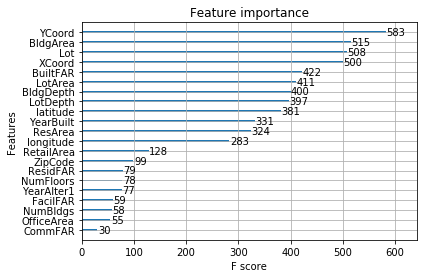

In [19]:
# plot feature importance
plot_importance(model)

In [30]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    results = []
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    results.append([thresh, select_X_train.shape[1], accuracy*100.0])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

AttributeError: 'list' object has no attribute 'columns'

In [22]:
!pip install graphviz

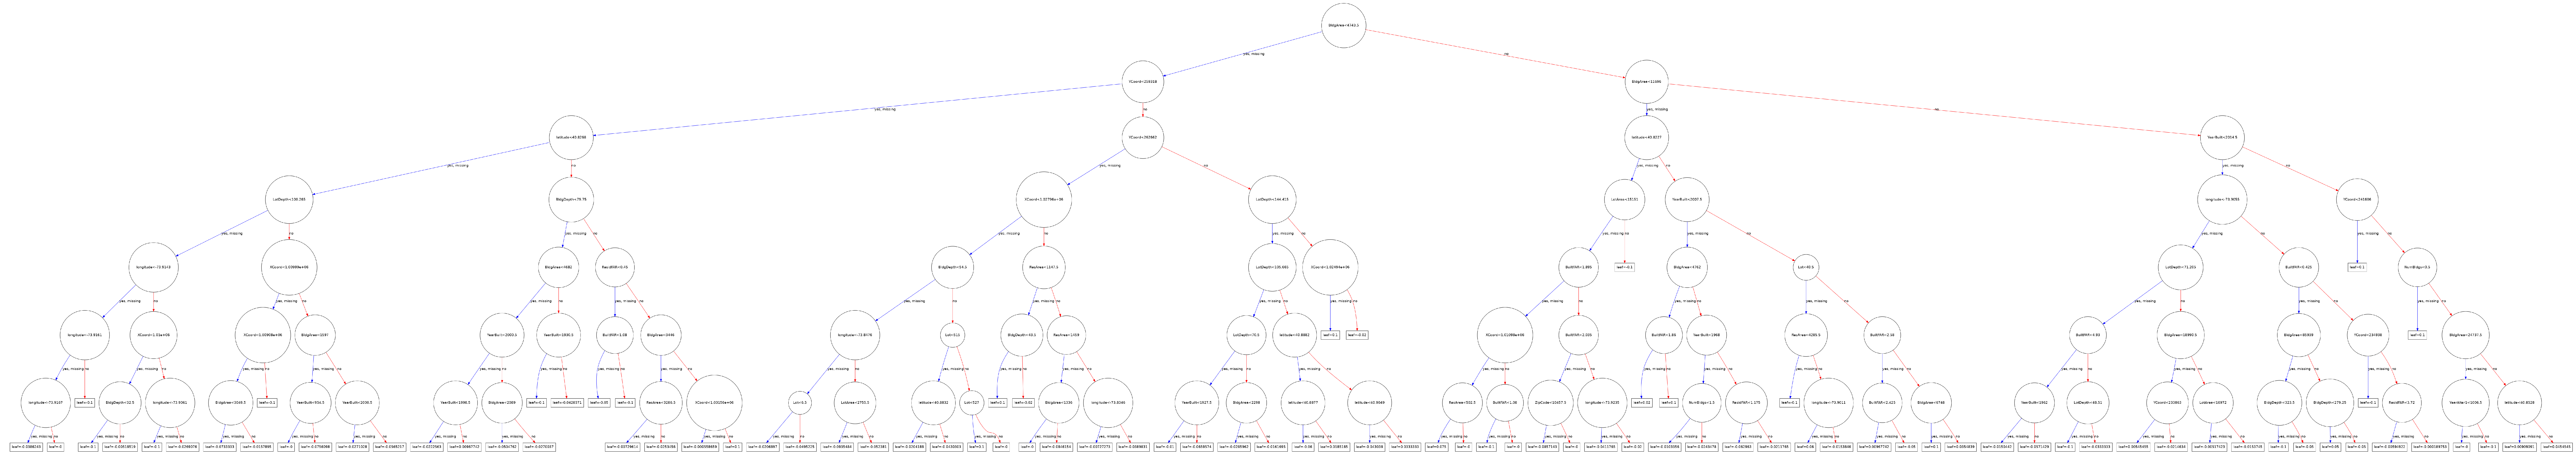

In [31]:
rcParams['figure.figsize'] = 200,100
plot_tree(model)
plt.show()

### AUC Area Under the Curve

The area under the curve is really bad, it means it is even worst than randomness

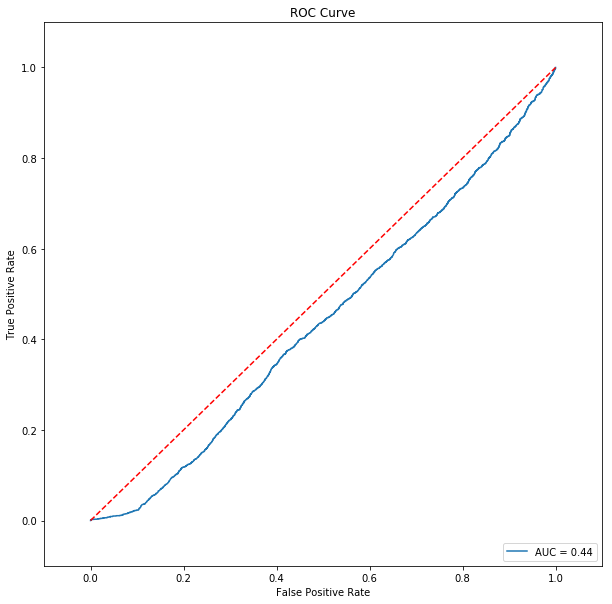

In [38]:
rcParams['figure.figsize'] = 10,10

y_preds = model.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()